# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 120000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (120000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(103932, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.61

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(103930, 10)


1    87254
0    16676
Name: Score, dtype: int64

In [16]:
Score=final['Score']

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
Based on the other review, I went and tried this tea.  As a choir member, I am always interested in licorice products since they soothe a worn voice.  However, many of the teas I have tried have too much ginger in it.  I was pleasantly surprised when I tried this tea.<br /><br />1) The licorice taste is subtle, but definitely present.<br /><br />2) No sugar necessary.  As a dentist, I love this.  The licorice flavor doesn't jump out at you at first, but around 4 or 5 seconds after swallowing, the licorice "dances" around the sides of your tongue.  I don't know how else to describe it, but it really does dance.  I've never had that

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
Based on the other review, I went and tried this tea.  As a choir member, I am always interested in licorice products since they soothe a worn voice.  However, many of the teas I have tried have too much ginger in it.  I was pleasantly surprised when I tried this tea.1) The licorice taste is subtle, but definitely present.2) No sugar necessary.  As a dentist, I love this.  The licorice flavor doesn't jump out at you at first, but around 4 or 5 seconds after swallowing, the licorice "dances" around the sides of your tongue.  I don't know how else to describe it, but it really does dance.  I've never had that before.  Brilliant!3) It's best w

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I was a bit disappointed in these.  They crumble very easily and have an unusual texture.  My son (6) does not like them.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I was a bit disappointed in these They crumble very easily and have an unusual texture My son 6 does not like them 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 103930/103930 [01:08<00:00, 1513.04it/s]


In [26]:
preprocessed_reviews[1500]

'bit disappointed crumble easily unusual texture son not like'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
    ## Similartly you can do preprocessing for review summary also.
    preprocessed_summary = []
    # tqdm is for printing the status bar
    for sentance in tqdm(final['Summary'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_summary.append(sentance.strip())

100%|██████████| 103930/103930 [01:09<00:00, 1506.03it/s]


# [4] Featurization

In [28]:
preprocessed_reviews=np.array(preprocessed_reviews)
preprocessed_summary=np.array(preprocessed_summary)
x_train=[]
x_test=[]
for i in range(int((preprocessed_reviews.shape[0]*0.7))+1):
    x_train.append(preprocessed_reviews[i]+" "+preprocessed_summary[i])
for i in range(int((preprocessed_reviews.shape[0]*0.7))+1,preprocessed_reviews.shape[0]):
    x_test.append(preprocessed_reviews[i]+" "+preprocessed_summary[i])
y_train=Score[:int((Score.shape[0]*0.7))+1]
y_test=Score[int((Score.shape[0]*0.7))+1:]
print(len(x_train))
print(len(x_test))
print(y_train.shape)
print(y_test.shape)

72752
31178
(72752,)
(31178,)


## [4.1] BAG OF WORDS

In [29]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts_train=count_vect.fit_transform(x_train)
final_counts_test=count_vect.transform(x_test)

## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=30)
final_tfidf_train=tf_idf_vect.fit_transform(x_train)
final_tfidf_test=tf_idf_vect.transform(x_test)

## [4.4] Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())

100%|██████████| 72752/72752 [00:00<00:00, 84375.41it/s] 


In [32]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance[:int((preprocessed_reviews.shape[0]*0.7))+1],min_count=5,size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.7983180284500122), ('excellent', 0.7777473330497742), ('awesome', 0.7686290740966797), ('terrific', 0.7261059880256653), ('wonderful', 0.7180896401405334), ('good', 0.7137693762779236), ('fabulous', 0.6099533438682556), ('nice', 0.6060447096824646), ('perfect', 0.6045916080474854), ('decent', 0.5774190425872803)]
[('greatest', 0.6797470450401306), ('nastiest', 0.6699617505073547), ('disgusting', 0.6659761071205139), ('best', 0.642784059047699), ('tastiest', 0.615796685218811), ('horrible', 0.6115448474884033), ('awful', 0.6004898548126221), ('coolest', 0.5731204152107239), ('humble', 0.5548417568206787), ('weakest', 0.5542643070220947)]


In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16563
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'sure', 'death', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'great', 'received', 'shipment', 'could', 'hardly']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

###### 1)On train data

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 72752/72752 [04:21<00:00, 278.18it/s]

72752
100


###### 2)On test data

In [35]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 31178/31178 [01:58<00:00, 262.25it/s]

31178
100


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

###### 1)On train data

In [37]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 72752/72752 [58:18<00:00, 23.41it/s]  


###### 2)On test data

In [38]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 31178/31178 [26:01<00:00, 27.82it/s]  


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [39]:
# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
lsvm=SGDClassifier(loss='hinge')
param_grid={"alpha":[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
my_cv = TimeSeriesSplit(n_splits=10)
grid=GridSearchCV(lsvm,param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time grid.fit(final_counts_train,y_train)

CPU times: user 1.07 s, sys: 1.28 s, total: 2.34 s
Wall time: 13.7 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### 1)Consusion matrix for test data

Accuracy for {'alpha': 0.001}
92.98543845018924
confusion matrix for test data
[[ 3786  1586]
 [  601 25205]]


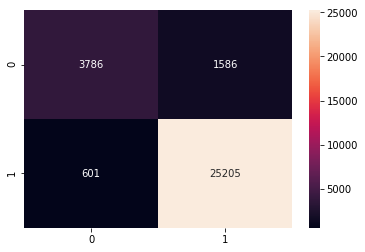

In [40]:

from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)


###### 2)Confusion matrix for train data

Accuracy for {'alpha': 0.001}
94.83862986584562
confusion matrix for train data
[[ 8367  2937]
 [  818 60630]]


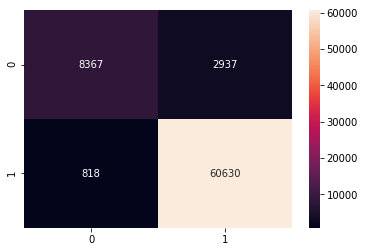

In [41]:
train_pre=grid.predict(final_counts_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

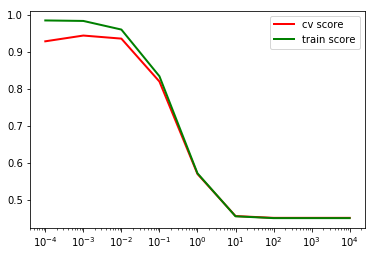

In [42]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["alpha"],cv_scores, param_grid["alpha"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

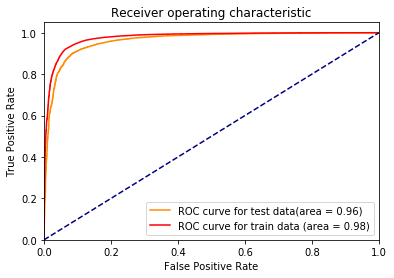

In [43]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_counts_train,y_train)
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

###### L1

In [44]:
grid=GridSearchCV(SGDClassifier(loss='hinge', penalty='l1'),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time grid.fit(final_counts_train,y_train)

CPU times: user 820 ms, sys: 180 ms, total: 1e+03 ms
Wall time: 8.26 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### 1)Confusion matrix for test data

Accuracy for {'alpha': 0.0001}
91.95586631599204
confusion matrix for test data
[[ 4142  1230]
 [ 1278 24528]]


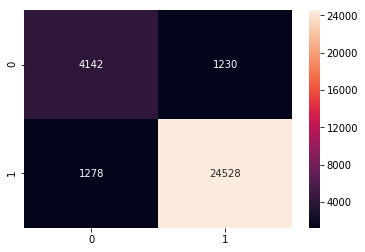

In [45]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

###### 2)Confusion matrix for train data

Accuracy for {'alpha': 0.0001}
93.18506707719375
confusion matrix for train data
[[ 8829  2475]
 [ 2483 58965]]


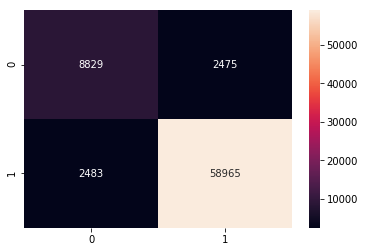

In [46]:
train_pre=grid.predict(final_counts_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

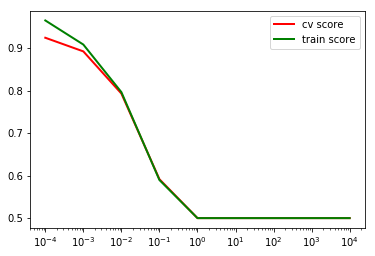

In [47]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["alpha"],cv_scores, param_grid["alpha"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

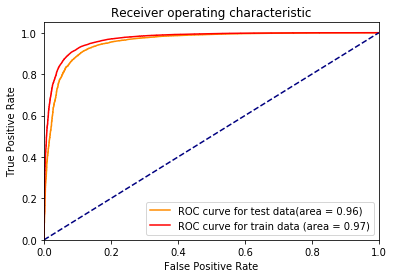

In [48]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_counts_train,y_train)
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [49]:
l1svm=SGDClassifier(loss='hinge', penalty='l2',alpha= 0.001)
l1svm.fit(final_counts_train,y_train)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
w=l1svm.coef_
w_sorted=np.argsort(w)
w_sorted

array([[51054, 12909, 45696, ..., 33519, 15679, 11951]])

###### Top 10 features

In [51]:
print("Top 10 important features of negative class:\n")
print(np.take(count_vect.get_feature_names(), w_sorted[0][:11]))
print("\nTop 10 important features of positive class:\n")
print(np.take(count_vect.get_feature_names(), w_sorted[0][-11:]))

Top 10 important features of negative class:

['worst' 'disappointing' 'terrible' 'awful' 'horrible' 'disappointed'
 'rip' 'disappointment' 'yuck' 'threw' 'poor']

Top 10 important features of positive class:

['tasty' 'wonderful' 'loves' 'best' 'great' 'awesome' 'yummy' 'amazing'
 'perfect' 'excellent' 'delicious']


(-0.5, 399.5, 199.5, -0.5)

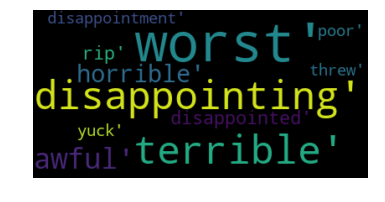

In [52]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(count_vect.get_feature_names(),w_sorted[0][:11])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

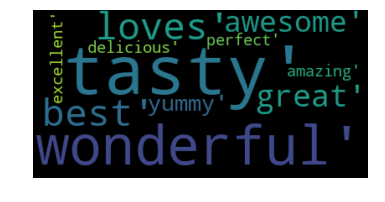

In [53]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(count_vect.get_feature_names(),w_sorted[0][-11:])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [54]:
grid=GridSearchCV(lsvm,param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 556 ms, sys: 152 ms, total: 708 ms
Wall time: 5.26 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### 1)Confusion matrix for test data

Accuracy for {'alpha': 0.0001}
93.14260055167105
confusion matrix for test data
[[ 3462  1910]
 [  228 25578]]


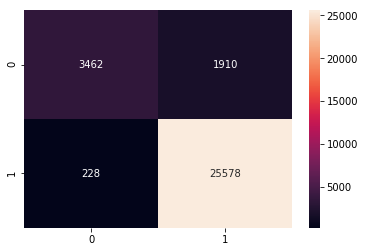

In [55]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

###### 2)Confusion matrix for train data

Accuracy for {'alpha': 0.0001}
94.11837475258412
confusion matrix for train data
[[ 7420  3884]
 [  395 61053]]


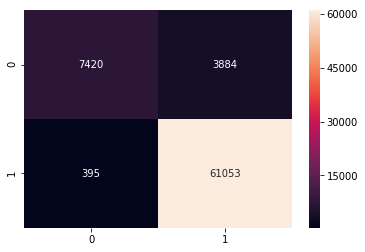

In [56]:
train_pre=grid.predict(final_tfidf_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

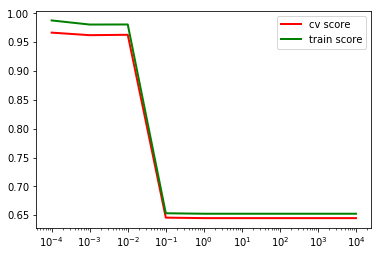

In [57]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["alpha"],cv_scores, param_grid["alpha"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

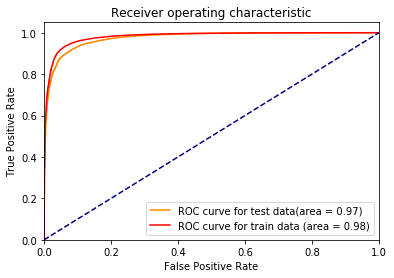

In [58]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train)
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

###### L1

In [59]:
grid=GridSearchCV(SGDClassifier(loss='hinge', penalty='l1'),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 812 ms, sys: 172 ms, total: 984 ms
Wall time: 6.76 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### 1)Confusion matrix for test data

Accuracy for {'alpha': 0.0001}
92.09057668869075
confusion matrix for test data
[[ 3212  2160]
 [  306 25500]]


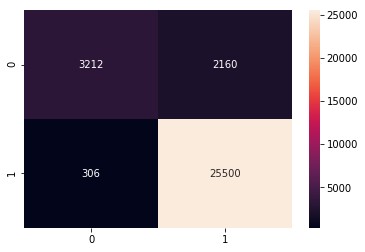

In [60]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

###### 2)Confusion matrix for train data

Accuracy for {'alpha': 0.0001}
92.36722014515065
confusion matrix for train data
[[ 6430  4874]
 [  679 60769]]


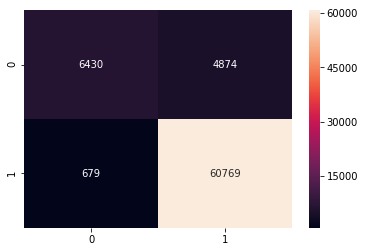

In [61]:
train_pre=grid.predict(final_tfidf_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

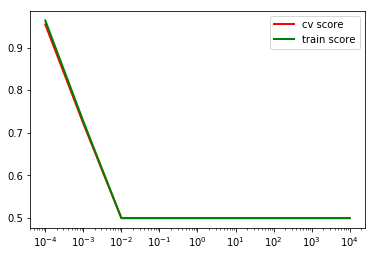

In [62]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["alpha"],cv_scores, param_grid["alpha"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

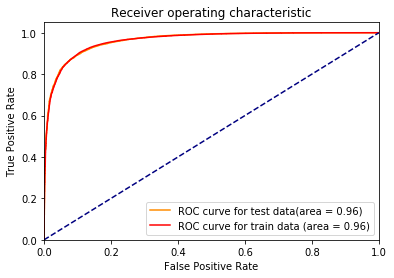

In [63]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train)
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [64]:
l1svm=SGDClassifier(loss='hinge', penalty='l2',alpha= 0.0001)
l1svm.fit(final_tfidf_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
w=l1svm.coef_
w_sorted=np.argsort(w)

###### Top features

In [66]:
print("Top 10 important features of negative class:\n")
print(np.take(tf_idf_vect .get_feature_names(), w_sorted[0][:11]))
print("\nTop 10 important features of positive class:\n")
print(np.take(tf_idf_vect .get_feature_names(), w_sorted[0][-11:]))

Top 10 important features of negative class:

['disappointed' 'not good' 'worst' 'not' 'horrible' 'awful' 'not worth'
 'terrible' 'disappointing' 'not buy' 'bad']

Top 10 important features of positive class:

['not bad' 'loves' 'tasty' 'not disappointed' 'perfect' 'love' 'excellent'
 'delicious' 'good' 'best' 'great']


(-0.5, 399.5, 199.5, -0.5)

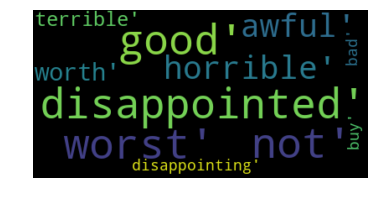

In [67]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(tf_idf_vect.get_feature_names(),w_sorted[0][:11])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

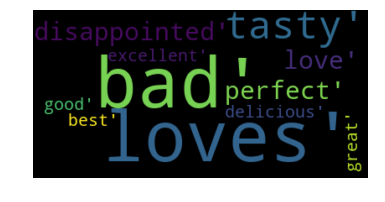

In [68]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(tf_idf_vect.get_feature_names(),w_sorted[0][-11:])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [69]:
# Please write all the code with proper documentation
grid=GridSearchCV(lsvm,param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time grid.fit(sent_vectors_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

CPU times: user 4min 5s, sys: 7.77 s, total: 4min 13s
Wall time: 4min 21s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### 1)Confusion matrix for test data

Accuracy for {'alpha': 0.001}
90.77875424979152
confusion matrix for test data
[[ 3156  2216]
 [  659 25147]]


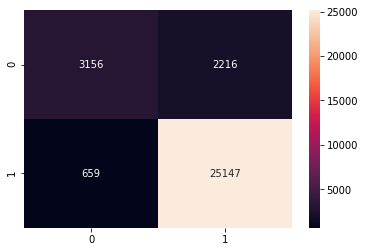

In [70]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

###### 2)Confusion matrix for train data

Accuracy for {'alpha': 0.001}
91.45040686166703
confusion matrix for train data
[[ 6515  4789]
 [ 1431 60017]]


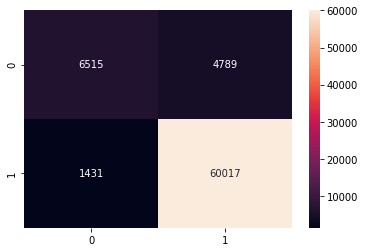

In [71]:
train_pre=grid.predict(sent_vectors_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

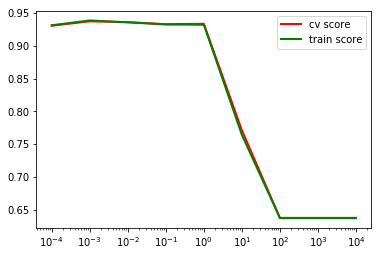

In [72]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["alpha"],cv_scores, param_grid["alpha"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

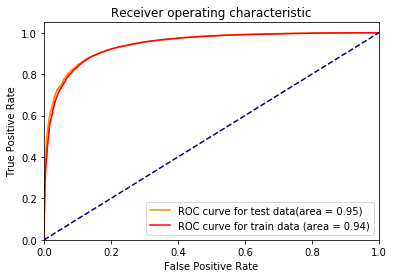

In [73]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

###### L1

In [74]:
grid=GridSearchCV(SGDClassifier(loss='hinge', penalty='l1'),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 4min 4s, sys: 6.53 s, total: 4min 10s
Wall time: 4min 19s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### 1)Confusion matrix for test data

Accuracy for {'alpha': 0.001}
90.60876258900507
confusion matrix for test data
[[ 3217  2155]
 [  773 25033]]


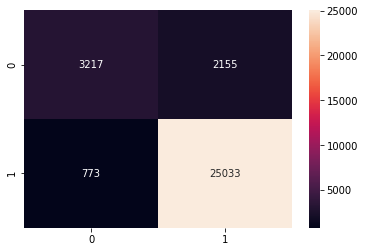

In [75]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

###### 2)Confusion matrix for train data

Accuracy for {'alpha': 0.001}
91.27859027930504
confusion matrix for train data
[[ 6608  4696]
 [ 1649 59799]]


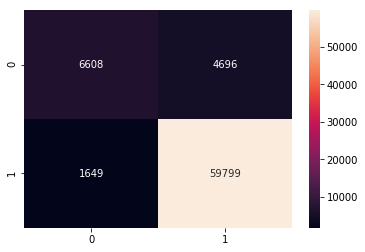

In [76]:
train_pre=grid.predict(sent_vectors_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

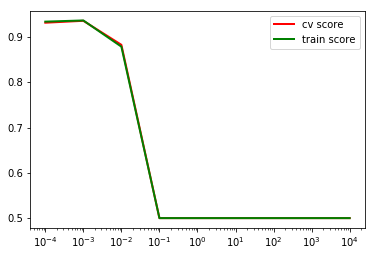

In [77]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["alpha"],cv_scores, param_grid["alpha"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

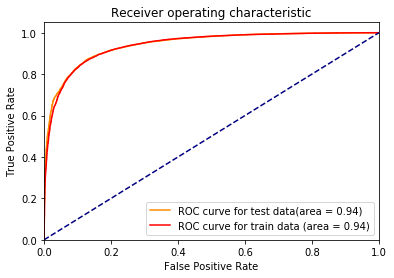

In [78]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [79]:
# Please write all the code with proper documentation
param_grid={"alpha":[10**-5,5*(10**-5),10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2]}
grid=GridSearchCV(lsvm,param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 4min 3s, sys: 6.99 s, total: 4min 10s
Wall time: 4min 19s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### 1)Confusion matrix for test data

Accuracy for {'alpha': 0.001}
89.27769581114889
confusion matrix for test data
[[ 2791  2581]
 [  762 25044]]


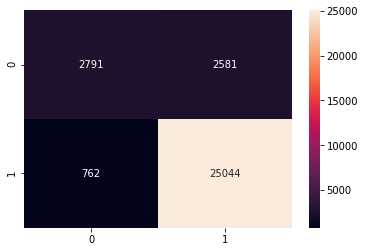

In [80]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

###### 2)Confusion matrix for train data

Accuracy for {'alpha': 0.001}
90.13772817242138
confusion matrix for train data
[[ 5820  5484]
 [ 1691 59757]]


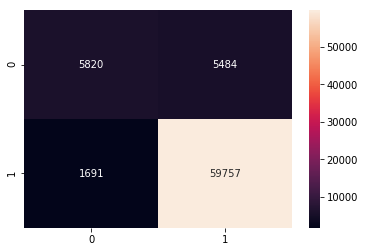

In [81]:
train_pre=grid.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

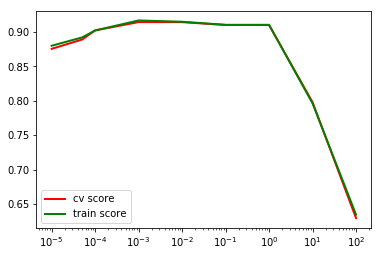

In [82]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["alpha"],cv_scores, param_grid["alpha"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

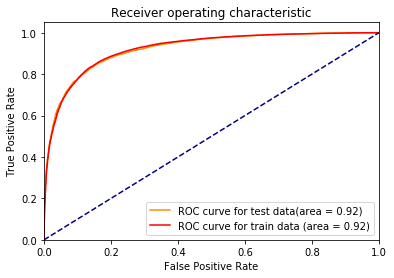

In [83]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

###### L1

In [84]:
grid=GridSearchCV(SGDClassifier(loss='hinge', penalty='l1'),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 4min 5s, sys: 6.85 s, total: 4min 11s
Wall time: 4min 20s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

###### 1)Confusion matrix for test data

Accuracy for {'alpha': 0.001}
88.9601642183591
confusion matrix for test data
[[ 2848  2524]
 [  918 24888]]


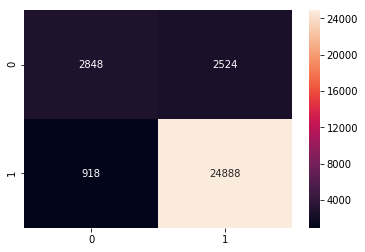

In [85]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

###### 2)Confusion matrix for train data

Accuracy for {'alpha': 0.001}
89.9562898614471
confusion matrix for train data
[[ 6043  5261]
 [ 2046 59402]]


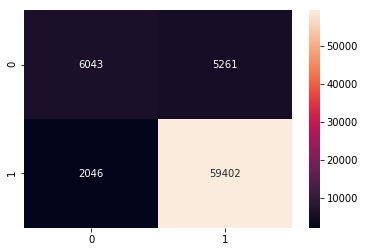

In [86]:
train_pre=grid.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

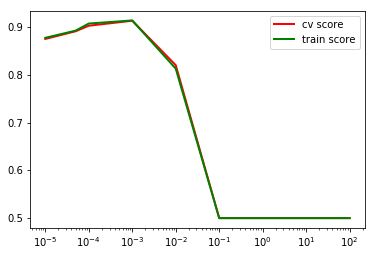

In [87]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["alpha"],cv_scores, param_grid["alpha"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

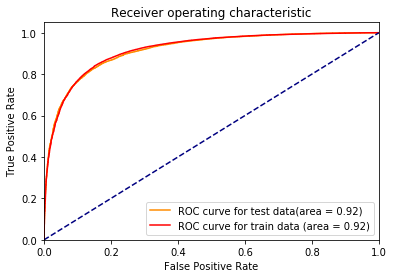

In [88]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [89]:
# Please write all the code with proper documentation
from sklearn.svm import SVC
param_grid={"C":[10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
rbf_grid_bow=GridSearchCV(SVC(),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time rbf_grid_bow.fit(final_counts_train[:20001],y_train[:20001])

CPU times: user 54.8 s, sys: 284 ms, total: 55.1 s
Wall time: 12min 19s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

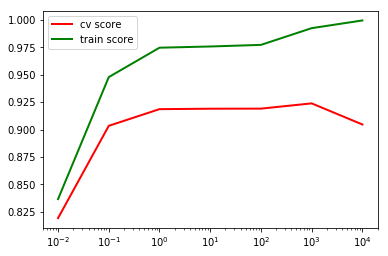

In [90]:
cv_scores=rbf_grid_bow.cv_results_ ['mean_test_score']
train_scores=rbf_grid_bow.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["C"],cv_scores, param_grid["C"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

In [91]:
c=rbf_grid_bow.best_params_ 

In [92]:
param_grid={"gamma":[10**-3,10**-2,10**-1,10**0,10**1,10**2]}
rbf_grid_bow=GridSearchCV(SVC(C=c['C']),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time rbf_grid_bow.fit(final_counts_train[:20001],y_train[:20001])

CPU times: user 3min 48s, sys: 256 ms, total: 3min 48s
Wall time: 1h 15min 10s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

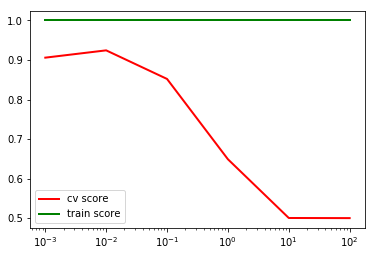

In [93]:
cv_scores=rbf_grid_bow.cv_results_ ['mean_test_score']
train_scores=rbf_grid_bow.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["gamma"],cv_scores, param_grid["gamma"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

Accuracy for {'gamma': 0.01} {'C': 1000}
90.94233113092565
confusion matrix for test data
[[ 3410  1962]
 [  862 24944]]


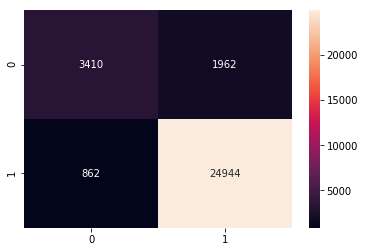

In [94]:
from sklearn.metrics import accuracy_score
optimal_param=rbf_grid_bow.best_params_ 
pre=rbf_grid_bow.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_param,c)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print("confusion matrix for test data")
print(conf_matr)

Accuracy for {'gamma': 0.01} {'C': 1000}
93.5465691664834
confusion matrix for test data
[[ 8031  3273]
 [ 1422 60026]]


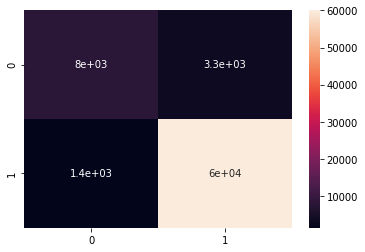

In [95]:
train_pre=rbf_grid_bow.predict(final_counts_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_param,c)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True)
print("confusion matrix for test data")
print(conf_matr)

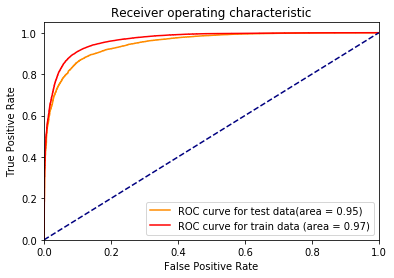

In [96]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(rbf_grid_bow.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_counts_train[:20001],y_train[:20001])
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [97]:
# Please write all the code with proper documentation
param_grid={"C":[10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
rbf_grid_tfidf=GridSearchCV(SVC(),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time rbf_grid_tfidf.fit(final_tfidf_train[:20001],y_train[:20001])

CPU times: user 1min 33s, sys: 936 ms, total: 1min 34s
Wall time: 14min 38s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

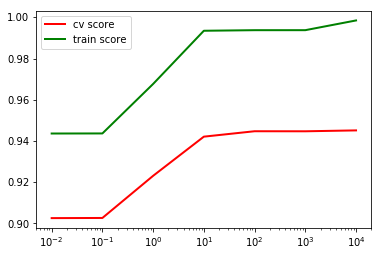

In [98]:
cv_scores=rbf_grid_tfidf.cv_results_ ['mean_test_score']
train_scores=rbf_grid_tfidf.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["C"],cv_scores, param_grid["C"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

In [99]:
c=rbf_grid_tfidf.best_params_ 

In [100]:
param_grid={"gamma":[10**-3,10**-2,10**-1,10**0,10**1,10**2]}
rbf_grid_tfidf=GridSearchCV(SVC(C=c['C']),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time rbf_grid_tfidf.fit(final_tfidf_train[:20001],y_train[:20001])

CPU times: user 7min 27s, sys: 308 ms, total: 7min 27s
Wall time: 1h 6min 34s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

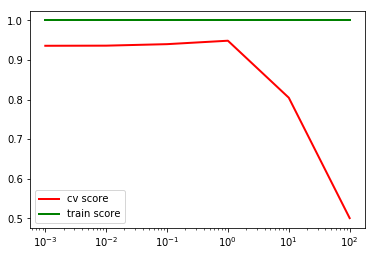

In [101]:
cv_scores=rbf_grid_tfidf.cv_results_ ['mean_test_score']
train_scores=rbf_grid_tfidf.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["gamma"],cv_scores, param_grid["gamma"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

Accuracy for {'gamma': 1} {'C': 10000}
92.38244916287127
confusion matrix for test data
[[ 3296  2076]
 [  299 25507]]


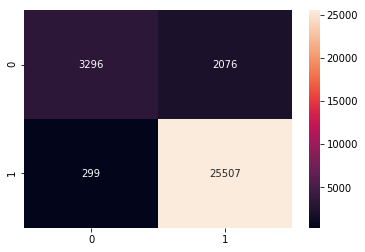

In [102]:
from sklearn.metrics import accuracy_score
optimal_k=rbf_grid_tfidf.best_params_ 
pre=rbf_grid_tfidf.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k,c)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

Accuracy for {'gamma': 1} {'C': 10000}
94.37403782713876
confusion matrix for train data
[[ 7695  3609]
 [  484 60964]]


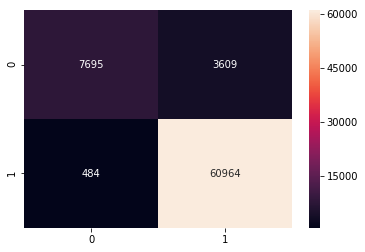

In [103]:
train_pre=rbf_grid_tfidf.predict(final_tfidf_train)
acc = accuracy_score(y_train, train_pre) * 100
print("Accuracy for",optimal_k,c)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

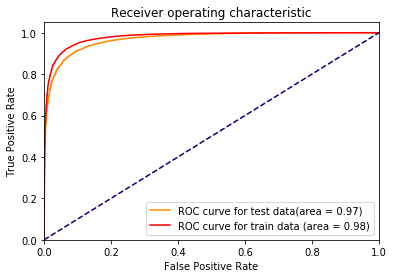

In [104]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(rbf_grid_tfidf.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train[:20001],y_train[:20001])
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [105]:
# Please write all the code with proper documentation
param_grid={"C":[10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
rbf_grid_avgw2v=GridSearchCV(SVC(),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time rbf_grid_avgw2v.fit(sent_vectors_train[:20001],y_train[:20001])

CPU times: user 1min 42s, sys: 1.3 s, total: 1min 44s
Wall time: 10min 8s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

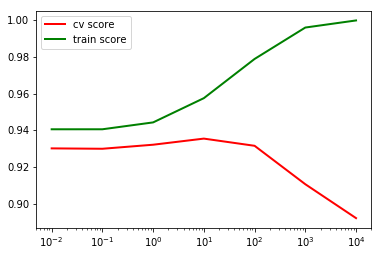

In [106]:
cv_scores=rbf_grid_avgw2v.cv_results_ ['mean_test_score']
train_scores=rbf_grid_avgw2v.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["C"],cv_scores, param_grid["C"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

In [107]:
c=rbf_grid_avgw2v.best_params_ 

In [108]:
param_grid={"gamma":[10**-3,10**-2,10**-1,10**0,10**1,10**2]}
rbf_grid_avgw2v=GridSearchCV(SVC(c['C']),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time rbf_grid_avgw2v.fit(sent_vectors_train[:20001],y_train[:20001])

CPU times: user 1min 29s, sys: 668 ms, total: 1min 30s
Wall time: 31min 53s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

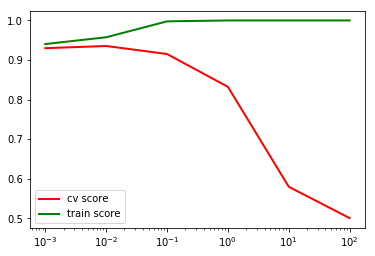

In [109]:
cv_scores=rbf_grid_avgw2v.cv_results_ ['mean_test_score']
train_scores=rbf_grid_avgw2v.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["gamma"],cv_scores, param_grid["gamma"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

Accuracy for {'gamma': 0.01} {'C': 10}
91.17967797806146
confusion matrix for test data
[[ 3258  2114]
 [  636 25170]]


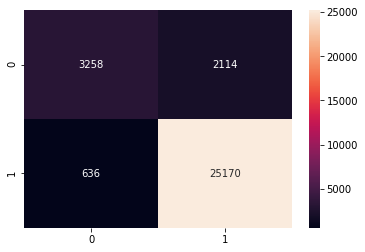

In [110]:
from sklearn.metrics import accuracy_score
optimal_k=rbf_grid_avgw2v.best_params_ 
pre=rbf_grid_avgw2v.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k,c)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

Accuracy for {'gamma': 0.01} {'C': 10}
91.92187156366836
confusion matrix for train data
[[ 6786  4518]
 [ 1359 60089]]


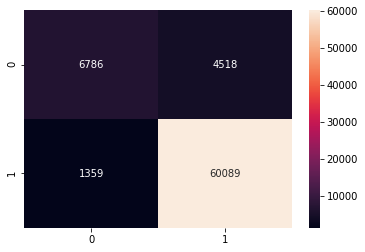

In [111]:
train_pre=rbf_grid_avgw2v.predict(sent_vectors_train)
acc = accuracy_score(y_train,train_pre) * 100
print("Accuracy for",optimal_k,c)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

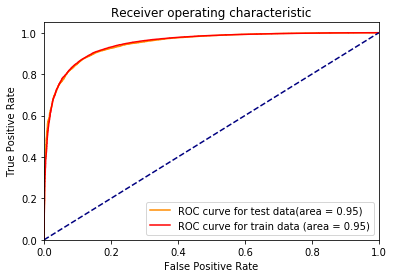

In [112]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(rbf_grid_avgw2v.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train[:20001],y_train[:20001])
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [113]:
# Please write all the code with proper documentation
param_grid={"C":[10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
rbf_grid_tfidfw2v=GridSearchCV(SVC(),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time rbf_grid_tfidfw2v.fit(tfidf_sent_vectors_train[:20001],y_train[:20001])

CPU times: user 1min 48s, sys: 1.36 s, total: 1min 49s
Wall time: 11min 28s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

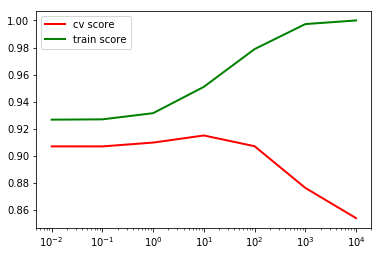

In [114]:
cv_scores=rbf_grid_tfidfw2v.cv_results_ ['mean_test_score']
train_scores=rbf_grid_tfidfw2v.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["C"],cv_scores, param_grid["C"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

In [115]:
c=rbf_grid_tfidfw2v.best_params_ 

In [116]:
param_grid={"gamma":[10**-3,10**-2,10**-1,10**0,10**1,10**2]}
rbf_grid_tfidfw2v=GridSearchCV(SVC(C=10**3),param_grid,cv=my_cv,scoring="roc_auc",n_jobs=-1)
%time rbf_grid_tfidfw2v.fit(tfidf_sent_vectors_train[:20001],y_train[:20001])

CPU times: user 2min, sys: 768 ms, total: 2min 1s
Wall time: 34min 1s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

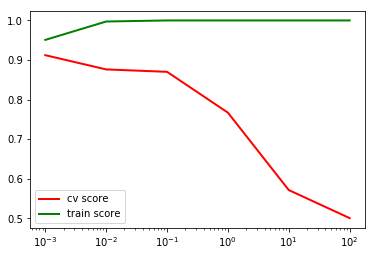

In [117]:
cv_scores=rbf_grid_tfidfw2v.cv_results_ ['mean_test_score']
train_scores=rbf_grid_tfidfw2v.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["gamma"],cv_scores, param_grid["gamma"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

Accuracy for {'gamma': 0.001} {'C': 10}
89.72993777663737
confusion matrix for test data
[[ 2767  2605]
 [  597 25209]]


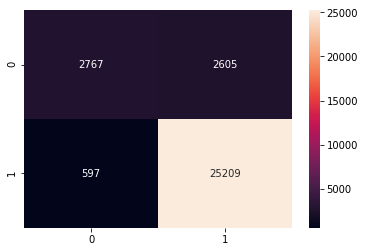

In [118]:
from sklearn.metrics import accuracy_score
optimal_k=rbf_grid_tfidfw2v.best_params_ 
pre=rbf_grid_tfidfw2v.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k,c)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for test data")
print(conf_matr)

Accuracy for {'gamma': 0.001} {'C': 10}
90.78100945678469
confusion matrix for train data
[[ 5952  5352]
 [ 1355 60093]]


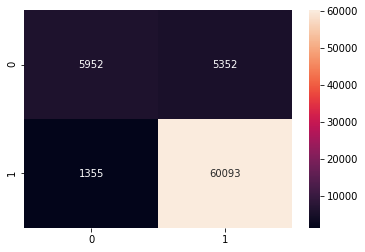

In [119]:
train_pre=rbf_grid_tfidfw2v.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train,train_pre) * 100
print("Accuracy for",optimal_k,c)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,train_pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print("confusion matrix for train data")
print(conf_matr)

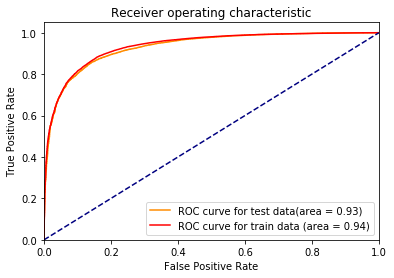

In [120]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(rbf_grid_tfidfw2v.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train[:20001],y_train[:20001])
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# [6] Conclusions

In [5]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
table= PrettyTable()
table.field_names = ["Vectorizer","Model","penalty","Accuracy","Hyperparameter","AUC"]
table.add_row(["Bow","Linear","l2",92.985,0.001,0.96])
table.add_row(["Bow","Linear","l1",91.955,0.0001,0.96])
table.add_row(["Tfidf","Linear","l2",93.142,0.0001,0.97])
table.add_row(["Tfidf","Linear","l1",92.090,0.0001,0.96])
table.add_row(["Avg-W2v","Linear","l2",90.778,0.001,0.95])
table.add_row(["Avg-W2v","Linear","l1",90.608,0.001,0.94])
table.add_row(["Tfidf-W2v","Linear","l2",89.277,0.001,0.92])
table.add_row(["Tfidf-W2v","Linear","l1",88.96,0.001,0.92])

In [6]:
print(table)

+------------+--------+---------+----------+----------------+------+
| Vectorizer | Model  | penalty | Accuracy | Hyperparameter | AUC  |
+------------+--------+---------+----------+----------------+------+
|    Bow     | Linear |    l2   |  92.985  |     0.001      | 0.96 |
|    Bow     | Linear |    l1   |  91.955  |     0.0001     | 0.96 |
|   Tfidf    | Linear |    l2   |  93.142  |     0.0001     | 0.97 |
|   Tfidf    | Linear |    l1   |  92.09   |     0.0001     | 0.96 |
|  Avg-W2v   | Linear |    l2   |  90.778  |     0.001      | 0.95 |
|  Avg-W2v   | Linear |    l1   |  90.608  |     0.001      | 0.94 |
| Tfidf-W2v  | Linear |    l2   |  89.277  |     0.001      | 0.92 |
| Tfidf-W2v  | Linear |    l1   |  88.96   |     0.001      | 0.92 |
+------------+--------+---------+----------+----------------+------+


In [7]:
table= PrettyTable()
table.field_names = ["Vectorizer","Model","penalty","Accuracy","gamma","C","AUC"]
table.add_row(["Bow","Rbf","l2",90.9423, 0.01,1000,0.95])
table.add_row(["Tfidf","Rbf","l2",92.38, 1,10000, 0.97])
table.add_row(["Avg-W2v","Rbf","l2",91.179, 0.01, 10, 0.95])
table.add_row(["Tfidf-W2v","Rbf","l2",89.72, 0.001, 10,0.93])

In [8]:
print(table)

+------------+-------+---------+----------+-------+-------+------+
| Vectorizer | Model | penalty | Accuracy | gamma |   C   | AUC  |
+------------+-------+---------+----------+-------+-------+------+
|    Bow     |  Rbf  |    l2   | 90.9423  |  0.01 |  1000 | 0.95 |
|   Tfidf    |  Rbf  |    l2   |  92.38   |   1   | 10000 | 0.97 |
|  Avg-W2v   |  Rbf  |    l2   |  91.179  |  0.01 |   10  | 0.95 |
| Tfidf-W2v  |  Rbf  |    l2   |  89.72   | 0.001 |   10  | 0.93 |
+------------+-------+---------+----------+-------+-------+------+


From the above table, it can be seen that,Linear SVM with TfIdf gave the highest AUC score with accuracy of 93.142% for c = 0.0001. 